In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [8]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

# Data Pre-Processing

Get clusters:

In [10]:
cluster_labels = pd.read_json('cluster_labels_dt1h.json')
pressure_factor = pd.read_json('pressure_factor_dt1h.json')
n_clusters = 30

Get results:

In [15]:
data_path_list = ['/home/ubuntu/gitrepos/Results/150sim_1hourSampling/',
                 '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/Validation/',
                 '']
for data_path in data_path_list:
    if os.path.isdir(data_path):
        print('Found data on: {}'.format(data_path))
        file_list = os.listdir(data_path)[:5]
        break


file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

Found data on: /home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/Validation/


# Load Model

In [72]:
model_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/models/03_series_LSTM/'

model = keras.models.load_model(model_path+'002_model_LSTM.h5')

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (768, 20, 80)             50240     
_________________________________________________________________
time_distributed_6 (TimeDist (768, 20, 20)             1620      
_________________________________________________________________
dropout_4 (Dropout)          (768, 20, 20)             0         
_________________________________________________________________
time_distributed_7 (TimeDist (768, 20, 20)             420       
_________________________________________________________________
dropout_5 (Dropout)          (768, 20, 20)             0         
_________________________________________________________________
time_distributed_8 (TimeDist (768, 20, 42)             882       
Total params: 53,162
Trainable params: 53,162
Non-trainable params: 0
__________________________________________________

## Create simple model:

In [74]:
nx = 76
ny = 42
stateful = True
seq_length= 20

n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [20]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 80
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2


model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 1, 80)                50240     
_________________________________________________________________
time_distributed_19 (TimeDis (1, 1, 20)                1620      
_________________________________________________________________
dropout_15 (Dropout)         (1, 1, 20)                0         
_________________________________________________________________
time_distributed_20 (TimeDis (1, 1, 20)                420       
_________________________________________________________________
dropout_16 (Dropout)         (1, 1, 20)                0         
_________________________________________________________________
time_distributed_21 (TimeDis (1, 1, 42)                882       
Total params: 53,162
Trainable params: 53,162
Non-trainable params: 0
____

In [75]:
with open(model_path+'train_data_param.pkl', 'rb') as f:
    train_data_param = pickle.load(f)

In [76]:
input_scaling = train_data_param['input_scaling']
output_scaling = train_data_param['output_scaling']

In [77]:
nn_input_list_scaled = [nn_in_i/input_scaling for nn_in_i in nn_input_list]
nn_output_list_scaled = [nn_out_i/output_scaling for nn_out_i in nn_output_list]

# Evaluate Model

Initialize hidden state:

In [82]:
model_simple.reset_states()
test_with = 0
nn_input = nn_input_list_scaled[test_with]
sys_states = nn_input_list[test_with]['sys_states']
sys_inputs = nn_input_list[test_with]['sys_inputs']
# Initialize hidden state:
t = 0
dt = 14400
init = seq_length
for i,in_i in nn_input.iloc[:init].iterrows():
    rnn_in_scaled = in_i.to_numpy().reshape(1,-1)
    model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    t += dt

In [83]:
x_arr = [sys_states.iloc[init].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[init:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(rnn_out[[0],:37])
    
res = np.concatenate(x_arr)

In [84]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

<IPython.core.display.Javascript object>


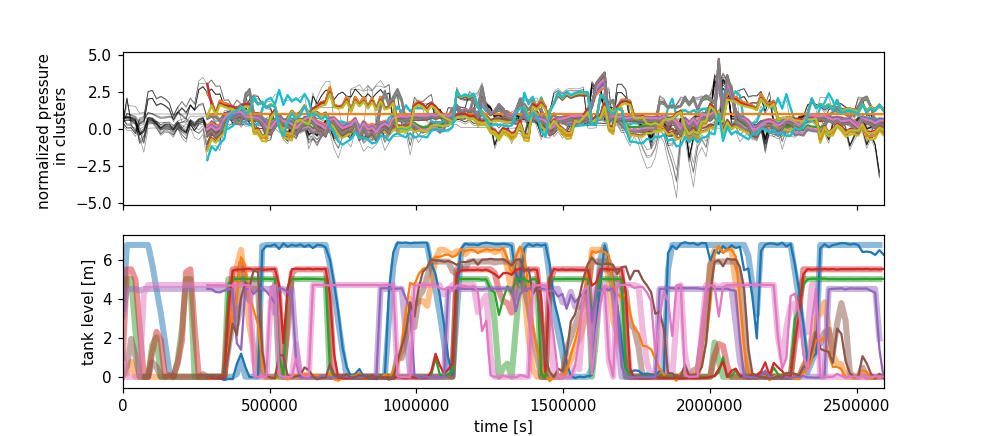

Text(0.5, 0, 'time [s]')

In [86]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,4))

sys_states['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
res['tank_press'].plot(ax=ax[1], legend=False)

ax[0].set_xlim(0, res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')